In [1]:
import scipy.io
import numpy as np
from scipy import optimize
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
y = mat['y']
del mat

mat = scipy.io.loadmat('ex4weights.mat') # Pre-trainned weight
theta1 = mat['Theta1']
theta2 = mat['Theta2']
del mat
m = X.shape[0]
t1s = theta1.shape
t2s = theta2.shape

# Plot random 100 images

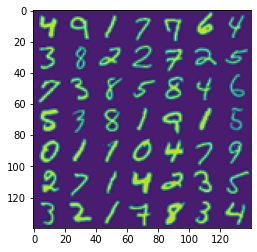

In [2]:
import matplotlib.pyplot as plt
def img_out(X_array,loc):
    return X_array[loc,:].reshape((20,-1)).T
plot_sqr = 7
img = np.zeros((plot_sqr*20,plot_sqr*20))
img_index = np.random.randint(0,high=X.shape[0],size=plot_sqr**2)
img_tmp = [X[i,:].reshape((20,-1)).T for i in img_index]
for i in range(plot_sqr):
    img[:,i*20:(i+1)*20,] =(np.array(img_tmp[i*plot_sqr:(i+1)*plot_sqr]).reshape((-1,20)))
plt.imshow(img)

# Testing Forward Propagation 

In [3]:
def sigmoid(z):
    return (1/(1+np.e**(-z)))
bias = np.ones(y.flatten().shape)
a1 = np.c_[bias,X].T  # shape = (banyak gambar x param)
z2 = theta1 @ a1
a2 = np.c_[bias,sigmoid(z2.T)].T # shape = (banyak gambar x param)
z3 = theta2 @ a2
a3 = sigmoid(z3)

# Change the output format from number to array

In [4]:
#plt.imshow(img_out(X,0))
y_a = np.zeros((10,5000)).astype('int32')
y_temp = np.where(y==10,0,y)
for i in range(5000):
    y_a[y_temp[i],i] = 1
y_a = np.r_[y_a[1:,:], y_a[0,:].reshape(1,-1)]

# Testing cost function

In [5]:
J1 = np.sum(-np.multiply(y_a,np.log(a3)) - np.multiply((1-y_a),np.log(1-a3)))/5000
lamb = 1
J2 = (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:]))) * lamb/10000
cost = J1 +J2
print(f'Cost w/o regularized is {J1:.6f} , expected value of 0.287629')
print(f'Cost w/  regularized is {cost:.6f}, expected value of 0.383770')

Cost w/o regularized is 0.287629 , expected value of 0.287629
Cost w/  regularized is 0.383770, expected value of 0.383770


# Create cost function and sigmoid gradient

In [6]:
def flattentheta(t1,t2):
    return np.r_[t1.flatten(),t2.flatten()]
    
def unflattentheta(thetax):
    sep = t1s[0] * t1s[1]
    t1 = thetax[:sep].reshape(t1s)
    t2 = thetax[sep:].reshape(t2s)
    return t1,t2

def forward_prop(X,th1,th2):
    bias = np.ones(m)
    a = np.c_[bias,X].T  # shape = (banyak gambar x param)
    b = th1 @ a
    c = np.c_[bias,sigmoid(b.T)].T # shape = (banyak gambar x param)
    d = th2 @ c
    e = sigmoid(d)
    return a,b,c,d,e #a1,z2,a2,z3,a3
    
thetax = flattentheta(theta1,theta2)

def J(theta,X,y,lambd=0):
    m = X.shape[0]
    th1,th2 = unflattentheta(theta)
    _,_,_,_,a3 = forward_prop(X,th1,th2)
    J1 = np.sum((-y * np.log(a3)) - ((1-y)* np.log(1-a3)))/m
    J2 = (np.sum(np.square(th1[:,1:])) + np.sum(np.square(th2[:,1:]))) * lambd/(2*m)
    return J1 + J2

def siggrad(z):
    return sigmoid(z)*(1-sigmoid(z)) 

print(f'Cost w/o regularized is {J(thetax,X,y_a):.6f} , expected value of 0.287629')
print(f'Cost w/  regularized is {J(thetax,X,y_a,1):.6f}, expected value of 0.383770')

Cost w/o regularized is 0.287629 , expected value of 0.287629
Cost w/  regularized is 0.383770, expected value of 0.383770


# Randomize init param

In [7]:
eps = 0.12
def randomtheta(ep):
    length = t1s[0] * t1s[1] + t2s[0] * t2s[1]
    return np.random.rand(length,)*2*ep -ep
    
theta_init = randomtheta(eps)

# Testing backpropagtion using pre-trained weight

In [8]:
m = 5000
theta1,theta2 = unflattentheta(thetax)
a1,z2,a2,z3,a3 = forward_prop(X,theta1,theta2)
lambd = 1
dk3 = a3-y_a
dk2 = (theta2.T @ dk3)[1:,:]* siggrad(z2)
print(theta2.shape)
Delta = dk2 @ a1.T / m 
Delta2 = dk3 @ a2.T / m 
Dx = flattentheta(Delta,Delta2)
Delta[:,1:] += (lambd/m) * theta1[:,1:]
Delta2[:,1:] += (lambd/m) * theta2[:,1:]

(10, 26)


# Gradient regularized neural network

In [9]:
def gradJ(theta,X,y,lambd=1):
    th1,th2 = unflattentheta(theta)
    a1,z2,a2,z3,a3 = forward_prop(X,th1,th2)
    dk3 = a3 - y
    dk2 = (th2.T @ dk3)[1:,:] * siggrad(z2)
    Delta = dk2 @ a1.T / m
    Delta2 = dk3 @ a2.T / m
    Delta[:,1:] += (lambd/m) * th1[:,1:]
    Delta2[:,1:] += (lambd/m) * th2[:,1:]
    return flattentheta(Delta,Delta2)

# Numerical regularized gradient cost function 

In [10]:
def gradapprox(theta,X,y,lambdx=1,epsi=1e-4,limit=100):
    gradJx = np.zeros(limit)
    p = np.zeros(theta.shape)
    theta_temp = theta.copy()
    for i in range(limit):
        p[i] = epsi
        J1x = J(theta_temp+p,X,y,lambdx)
        J2x = J(theta_temp-p,X,y,lambdx)
        p[i] = 0
        gradJx[i] = J1x-J2x
    return gradJx/(2*epsi)

# Testing backprop function on first 100 param using numerical gradient cost function

In [11]:
ax = gradapprox(thetax,X,y_a,lambdx=5,epsi=1e-10,limit=100)
ay = gradJ(thetax,X,y_a,lambd=5)
sumval = np.sum(np.abs(ax-ay[:100]))/100
print(f'The absolute sum error for 100 first params is {sumval*1e7:.5f} * 1e-7')

The absolute sum error for 100 first params is 2.60273 * 1e-7


# Training the neural network

In [12]:
import pickle
def accuracy(th):
    th1,th2 = unflattentheta(th)
    _,_,_,_,a3 = forward_prop(X,th1,th2)
    return np.average((((np.argmax(a3,axis=0)+1) == y.flatten().astype('int64'))*1))

pt = True # Using pre-trainned weights
if pt:
    optimizer = pickle.load(open('theta0.p','rb'))
else:
    theta_init = randomtheta(eps)
    optimizer = optimize.minimize(fun=J, x0=theta_init,args=(X,y_a,5), method ='L-BFGS-B', jac=gradJ,options={'maxiter':1000})
    pickle.dump(optimizer,open('theta0.p','wb'))
theta_init = optimizer.x
print(optimizer)
print(f'Training accuracy = {accuracy(theta_init)*100:.3f}%')

ModuleNotFoundError: No module named 'scipy.optimize._optimize'

# Visualize the paramaters

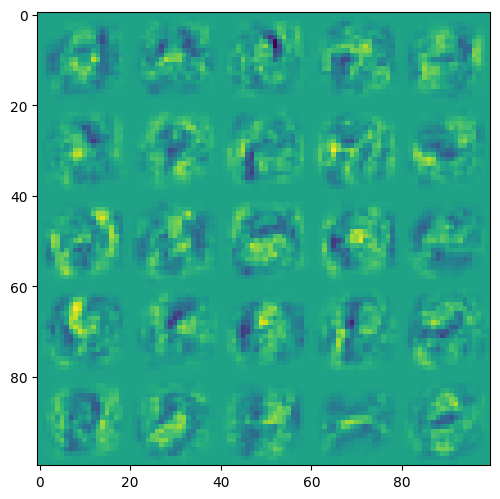

In [ ]:
t1,t2 = unflattentheta(theta_init)
im_test = t1[:,1:]
img = np.zeros((100,100))
c = 0 
for i in range(5):
    for j in range(5):
        img[i*20:(i+1)*20,j*20:(j+1)*20] = im_test[c,:].reshape((20,-1))
        c+=1
plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(img)